# Subset and cluster data using trained condVAE model

Using the trained `condVAE` model, this tutorial looks at how to cluster the learned latent representation into CSLs. 
First, we will create and cluster a smaller subset of the large dataset.
After this follows and interactive clustering and annotation step. 
This notebook contains some example code on how to quickly cluster the data and look at the results. 
We can also look at the clustering on example cells.
Then, we will prepare the entire dataset for prediction.
Finally, the resulting clustering will be projected to the entire data.

In [57]:
import os

import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

from campa.pl import annotate_img
from campa.tl import (
    Cluster,
    Experiment,
    create_cluster_data,
    prepare_full_dataset,
    project_cluster_data,
)
from campa.data import MPPData
from campa.constants import EXPERIMENT_DIR
from campa.tl._cluster import add_clustering_to_adata

## Prepare a subset of the data
Subsetting and clustering the data can be done with the high-level API, using `campa.tl.create_cluster_data`.
Alternatively, the cli can be used:
```
campa cluster test/CondVAE_pred-CC create --subsample --frac 0.1 --save-dir aggregated/sub-0.1 --cluster
```

If you would like to also directly cluster the data, use `cluster=True` in the call to `create_cluster_data`. Here, we leave the clustering for the interactive clustering and annotation step below.

In [4]:
create_cluster_data("test/CondVAE_pert-CC", subsample=True, frac=0.1, save_dir="aggregated/sub-0.1")

2022-03-23 17:45:50.691495: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Saving partial keys of mpp data without a base_data_dir to enable correct loading


/Users/hannah.spitzer/opt/miniconda3/envs/campa/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Saving partial keys of mpp data without a base_data_dir to enable correct loading


## Prepare full dataset for projecting cluster to it
To project the clustering to the entire dataset, the model needs to be used to predict the latent representation on all data. 
It is recommended to run this step in a script, as this might take a while for large datasets:
```
campa cluster prepare-full test/condVAE_pert-CC --save-dir aggregated/full_data
```
This script uses the `prepare_full_dataset` function of the high-level API.

In [35]:
prepare_full_dataset("test/condVAE_pert-CC", save_dir="aggregated/full_data")

KeyboardInterrupt: 

## Interactive clustering and annotation
Now we can cluster our data. This is done by getting an `adata` object from the `Cluster` object and clustering it using `scanpy`. 

TODO Plotting functions should probably go in the package code

In [9]:
# load cl
cluster_data_dir = "test/CondVAE_pert-CC/aggregated/sub-0.1"
cl = Cluster.from_cluster_data_dir(cluster_data_dir)
# get adata object
adata = cl.cluster_mpp.get_adata(X="mpp", obsm={"X_latent": "latent", "X_umap": "umap"})

Cannot read with memmap:  /Users/hannah.spitzer/projects/pelkmans/local_experiments/NascentRNA_new/test/CondVAE_pert-CC/aggregated/sub-0.1/clustering.npy


/Users/hannah.spitzer/opt/miniconda3/envs/campa/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Cluster the latent space. Here, different clusterings with different resolutions could be created and compared.

In [12]:
# cluster the latent space
sc.pp.neighbors(adata, use_rep="X_latent")
sc.tl.leiden(adata, resolution=0.2, key_added="clustering_res0.2", random_state=0)

In [15]:
# write clustering to disk
np.save(os.path.join(EXPERIMENT_DIR, cluster_data_dir, "clustering_res0.2"), adata.obs["clustering_res0.2"])

### Explore clustered data
Let us define some convenience function to explore the clustering

In [37]:
# quick plotting functions for looking at results
def plot_loadings(adata, var="clustering"):
    pixel_values_annotated = pd.concat(
        [
            pd.DataFrame(adata.X, columns=adata.var_names).reset_index(drop=True),
            adata.obs[[var]].reset_index(drop=True),
        ],
        axis=1,
    )
    # col_standard = sns.clustermap(pixel_values_annotated.groupby(var).aggregate('mean'), z_score=0, cmap="vlag", figsize=[10,4],vmin=-3, vmax=3)
    _ = sns.clustermap(
        pixel_values_annotated.groupby(var).aggregate("mean"),
        z_score=1,
        cmap="vlag",
        figsize=[14, 9],
        vmin=-3,
        vmax=3,
        method="ward",
    )


def plot_count_per_condition(var="clustering"):
    count_per_condition = (
        adata.obs[["mapobject_id", "perturbation_duration", var]].groupby(["perturbation_duration", var]).agg(["count"])
    )
    count_per_condition.reset_index(level=0, inplace=True)
    count_per_condition = count_per_condition.pivot(columns="perturbation_duration")
    count_per_condition = count_per_condition / count_per_condition.sum()
    count_per_condition.index = count_per_condition.index.astype(int)
    count_per_condition = count_per_condition.sort_index()

    plt.rcParams["figure.figsize"] = [10, 14]
    fig, axes = plt.subplots(2, 1)

    axes[0] = count_per_condition.plot.bar(ax=axes[0])
    axes[1] = sns.heatmap(count_per_condition.transpose())


# projection function to example subset
def project_clustering(cl, mpp_data: MPPData, obj_ids=(), num_objs=5, cluster_name="clustering"):
    """
    project clustering to example obj_ids.
    Either a list of obj_ids can be specified, or a number of randomly drawn objects.

    Args:
        cl: reference clustering
        mpp_data: data containing the obj_ids to project
    """
    # set cluster_name to project
    cl.set_cluster_name(cluster_name)
    if len(obj_ids) == 0:
        rng = np.random.default_rng(seed=42)
        obj_ids = rng.choice(mpp_data.unique_obj_ids, num_objs, replace=False)
    sub_mpp_data = mpp_data.subset(obj_ids=obj_ids, copy=True)
    sub_mpp_data = cl.project_clustering(sub_mpp_data)
    return sub_mpp_data


def load_full_data_dict(exp_name, keys=("x", "y", "obj_ids", "latent")):
    """
    load mpp_datas used in experiment exp_name in a dict.
    NOTE: this might take a few minutes, as all data needs to be loaded.

    Args:
        keys: controls which np data matrices are being loaded. Excluding mpp here speeds up loading
    """
    exp = Experiment.from_dir(exp_name)
    mpp_datas = {}
    for data_dir in exp.data_params["data_dirs"]:
        print(data_dir)
        try:
            mpp_datas[data_dir] = MPPData.from_data_dir(
                data_dir, base_dir=os.path.join(exp.full_path, "aggregated/full_data"), keys=keys, optional_keys=[]
            )
        except FileNotFoundError:
            # raise(e)
            pass
    return mpp_datas


def get_clustered_cells(mpp_datas, cl, cluster_name, num_objs=5):
    """
    get x example cells for each well. Returns a dict, containing clustering cluster_name and colored cells in cluster_name_colored
    """
    cl.set_cluster_name(cluster_name)
    res = {cluster_name: {}, cluster_name + "_colored": {}}
    for data_dir, mpp_data in mpp_datas.items():
        print(data_dir)
        sub_mpp_data = project_clustering(cl, mpp_data, num_objs=num_objs, cluster_name=cluster_name)
        # if only need colored cells, can pass annotation_kwargs to get_object_imgs
        res[cluster_name][data_dir] = sub_mpp_data.get_object_imgs(
            data=cluster_name
        )  # annotation_kwargs={'color': True, 'annotation': cl.cluster_annotation})
        res[cluster_name + "_colored"][data_dir] = [
            annotate_img(img, annotation=cl.cluster_annotation, from_col=cluster_name, color=True)
            for img in res[cluster_name][data_dir]
        ]
    return res

Load the `Cluster` object, and export it and the just created clustering to an adata object. 
TODO: more explanation about clustering and cluster annotations

In [19]:
# load cl
cl = Cluster.from_cluster_data_dir(cluster_data_dir)
# get adata object
adata = cl.cluster_mpp.get_adata(X="mpp", obsm={"X_latent": "latent", "X_umap": "umap"})
# add clustering and colormap (from cluster_name_annotation.csv) to adata
cl.set_cluster_name("clustering_res0.2")
add_clustering_to_adata(
    os.path.join(EXPERIMENT_DIR, cluster_data_dir), "clustering_res0.2", adata, cl.cluster_annotation
)

Cannot read with memmap:  /Users/hannah.spitzer/projects/pelkmans/local_experiments/NascentRNA_new/test/CondVAE_pert-CC/aggregated/sub-0.1/clustering.npy
Cannot read with memmap:  /Users/hannah.spitzer/projects/pelkmans/local_experiments/NascentRNA_new/test/CondVAE_pert-CC/aggregated/sub-0.1/clustering_res0.2.npy


/Users/hannah.spitzer/opt/miniconda3/envs/campa/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


The following is a UMAP of the latent space coordinates of each pixel. It is useful to check that the clustering algorithm is doing something sensible, and also that the conditions used in the autoencoder don't end up in different regions of the latent space UMAP (which would indicate that the conditional autoencoder was not able to generate a condition-independent representation). Channel intensities can also be visualised here, which is useful if you have some markers for known structures (e.g. NCL, H3, SON) 

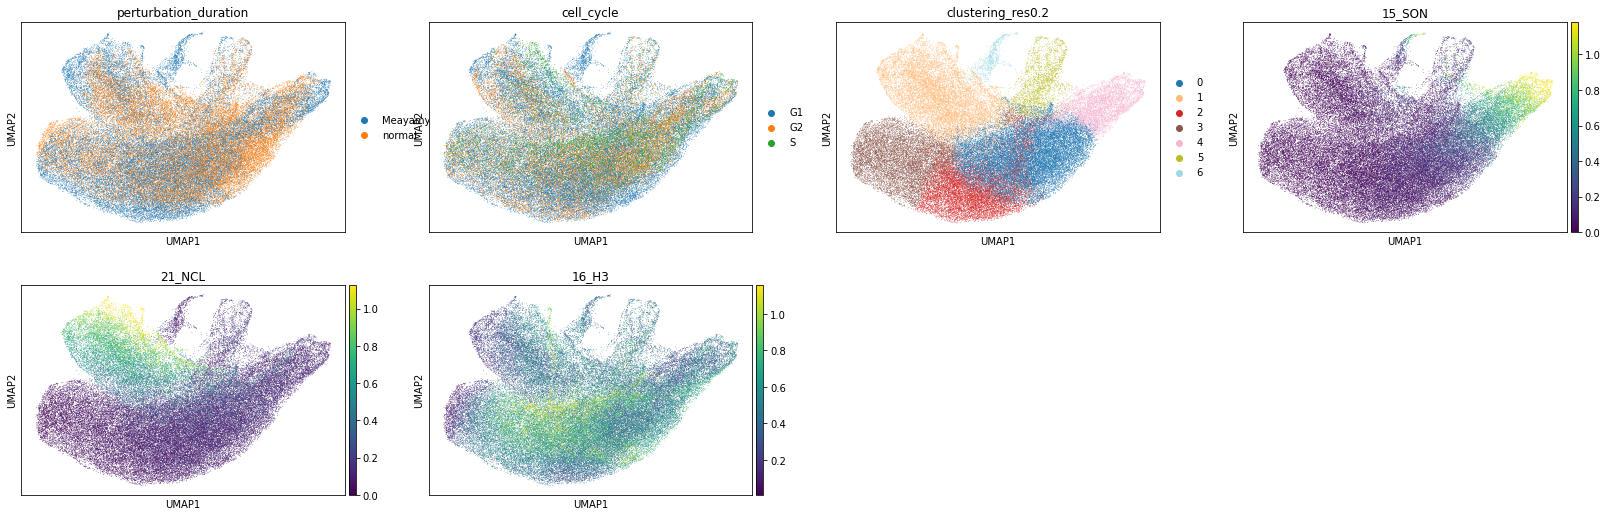

In [24]:
plt.rcParams["figure.figsize"] = [6, 4]
sc.pl.umap(
    adata, color=["perturbation_duration", "cell_cycle", "clustering_res0.2", "15_SON", "21_NCL", "16_H3"], vmax="p99"
)

To get an idea of what cellular compartments the channels correspond to, it is best to plot the mean intensity of each channel in each cluster. The `plot_loadings` function is used for this 

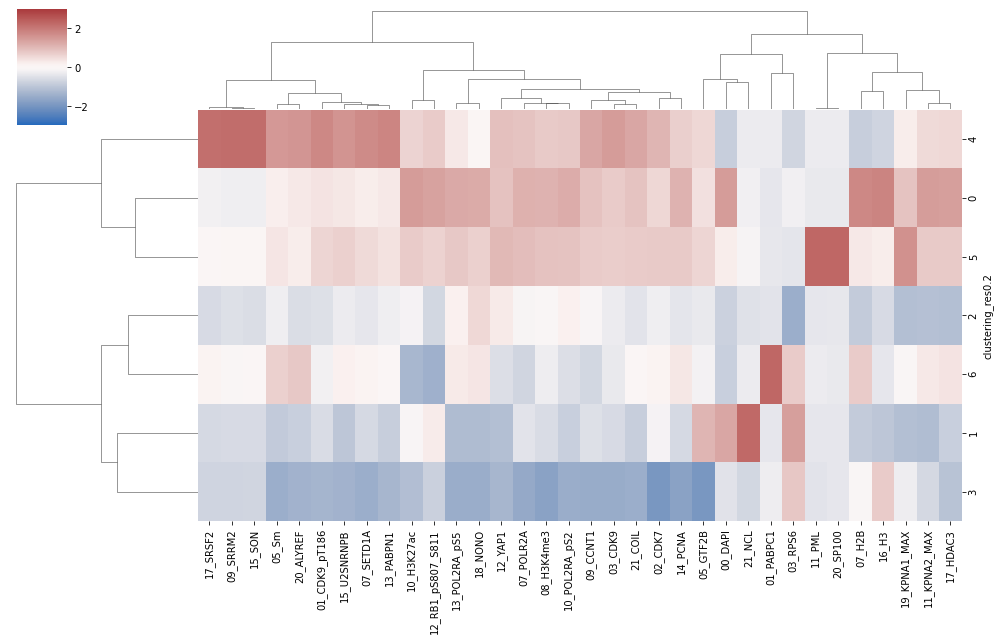

In [25]:
plot_loadings(adata, "clustering_res0.2")

It is also very useful to plot the clusters directly out over some example cells. The `get_clustered_cells` function will return some random cells from each well of the experiment

In [38]:
# NOTE: this may take a couple of minutes
# load data
mpp_datas = load_full_data_dict("test/CondVAE_pert-CC")
# project clustering to some example cells
example_cells = {}
example_cells.update(get_clustered_cells(mpp_datas, cl, "clustering_res0.2", num_objs=3))

184A1_unperturbed/I09
184A1_unperturbed/I11
184A1_meayamycin/I12
184A1_meayamycin/I20
184A1_unperturbed/I09
184A1_unperturbed/I11


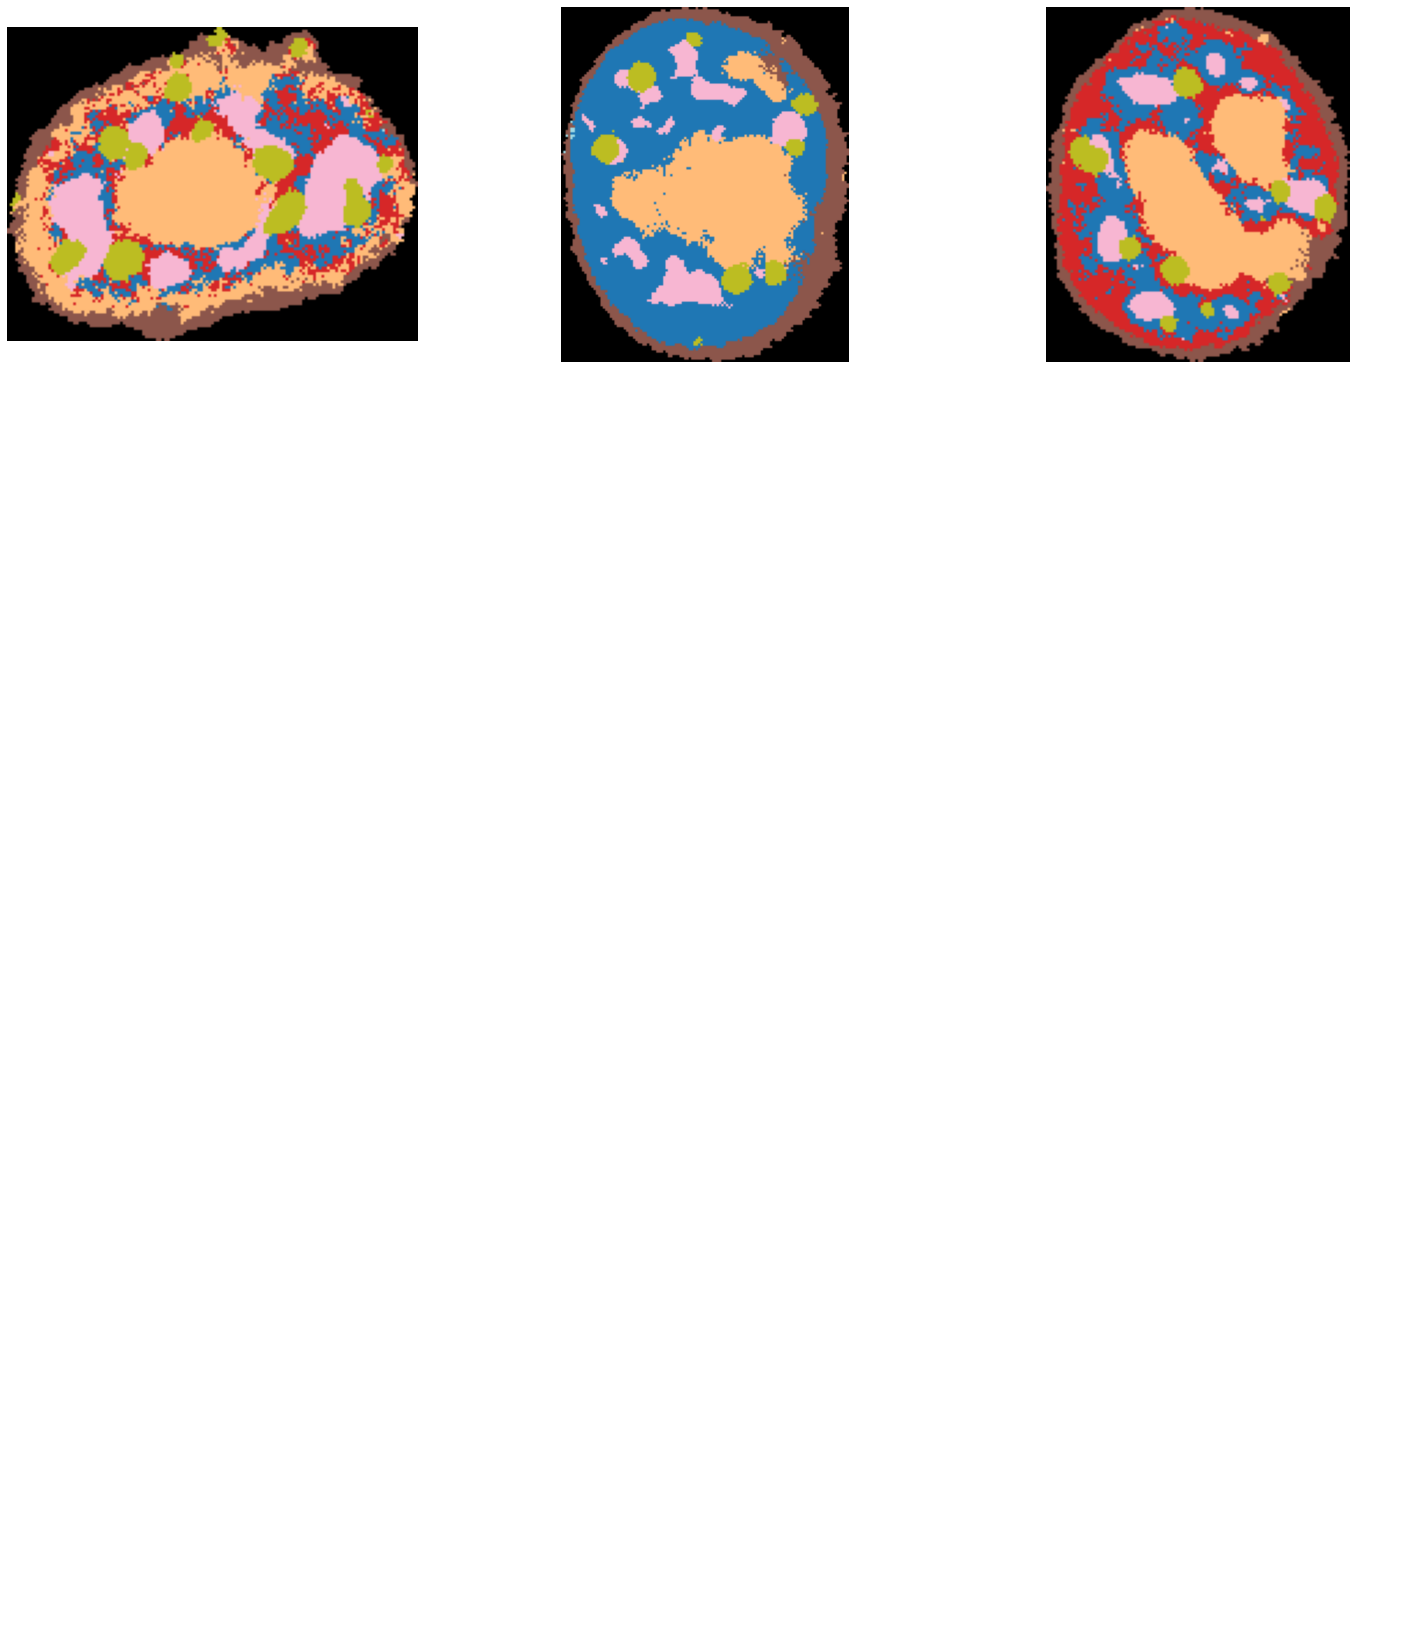

In [48]:
fig, axes = plt.subplots(4, 3, figsize=(25, 30))
for j, data_dir in enumerate(["184A1_unperturbed/I09"]):
    for i in range(3):
        axes[j, i].imshow(example_cells["clustering_res0.2_colored"][data_dir][i])

for ax in axes.flat:
    ax.axis("off")

### Annotate clustering
Now, we are ready to annotate the clustering with known structure names. Note that this annotation might vary slightly when rerunning this experiment and clustering, due to the inherent randomness of neural network training.

For the annotation, we will create a dictionary mapping leiden cluster names to annotated names, and use the function `add_cluster_annotation` to the `Cluster` object. Annotations and color maps for the annotations are stored in a csv file in the `cluster_data_dir`.

TODO mention that can also set colors for CSLs

In [53]:
annotation = {
    "0": "Nucleoplasm",
    "1": "Nucleolus",
    "2": "Nucleoplasm",
    "3": "Nuclear periphery",
    "4": "Nuclear speckles",
    "5": "PML bodies",
    "6": "Nucleoplasm",
}

cl.set_cluster_name("clustering_res0.2")
cl.add_cluster_annotation(annotation, "annotation")

# check out the resulting cluster annotation data frame - this is stored in cluster_data_dir/clustering_res0.2_annotation.csv
cl.cluster_annotation

,clustering_res0.2,clustering_res0.2_colors,annotation,annotation_colors
index,,,,
0,0,#1f77b4,Nucleoplasm,#c7c7c7
1,1,#ffbb78,Nucleolus,#8c564b
2,2,#d62728,Nucleoplasm,#c7c7c7
3,3,#8c564b,Nuclear periphery,#1f77b4
4,4,#f7b6d2,Nuclear speckles,#98df8a
5,5,#bcbd22,PML bodies,#9edae5
6,6,#9edae5,Nucleoplasm,#c7c7c7
7,,#ffffff,NaN,#ffffff


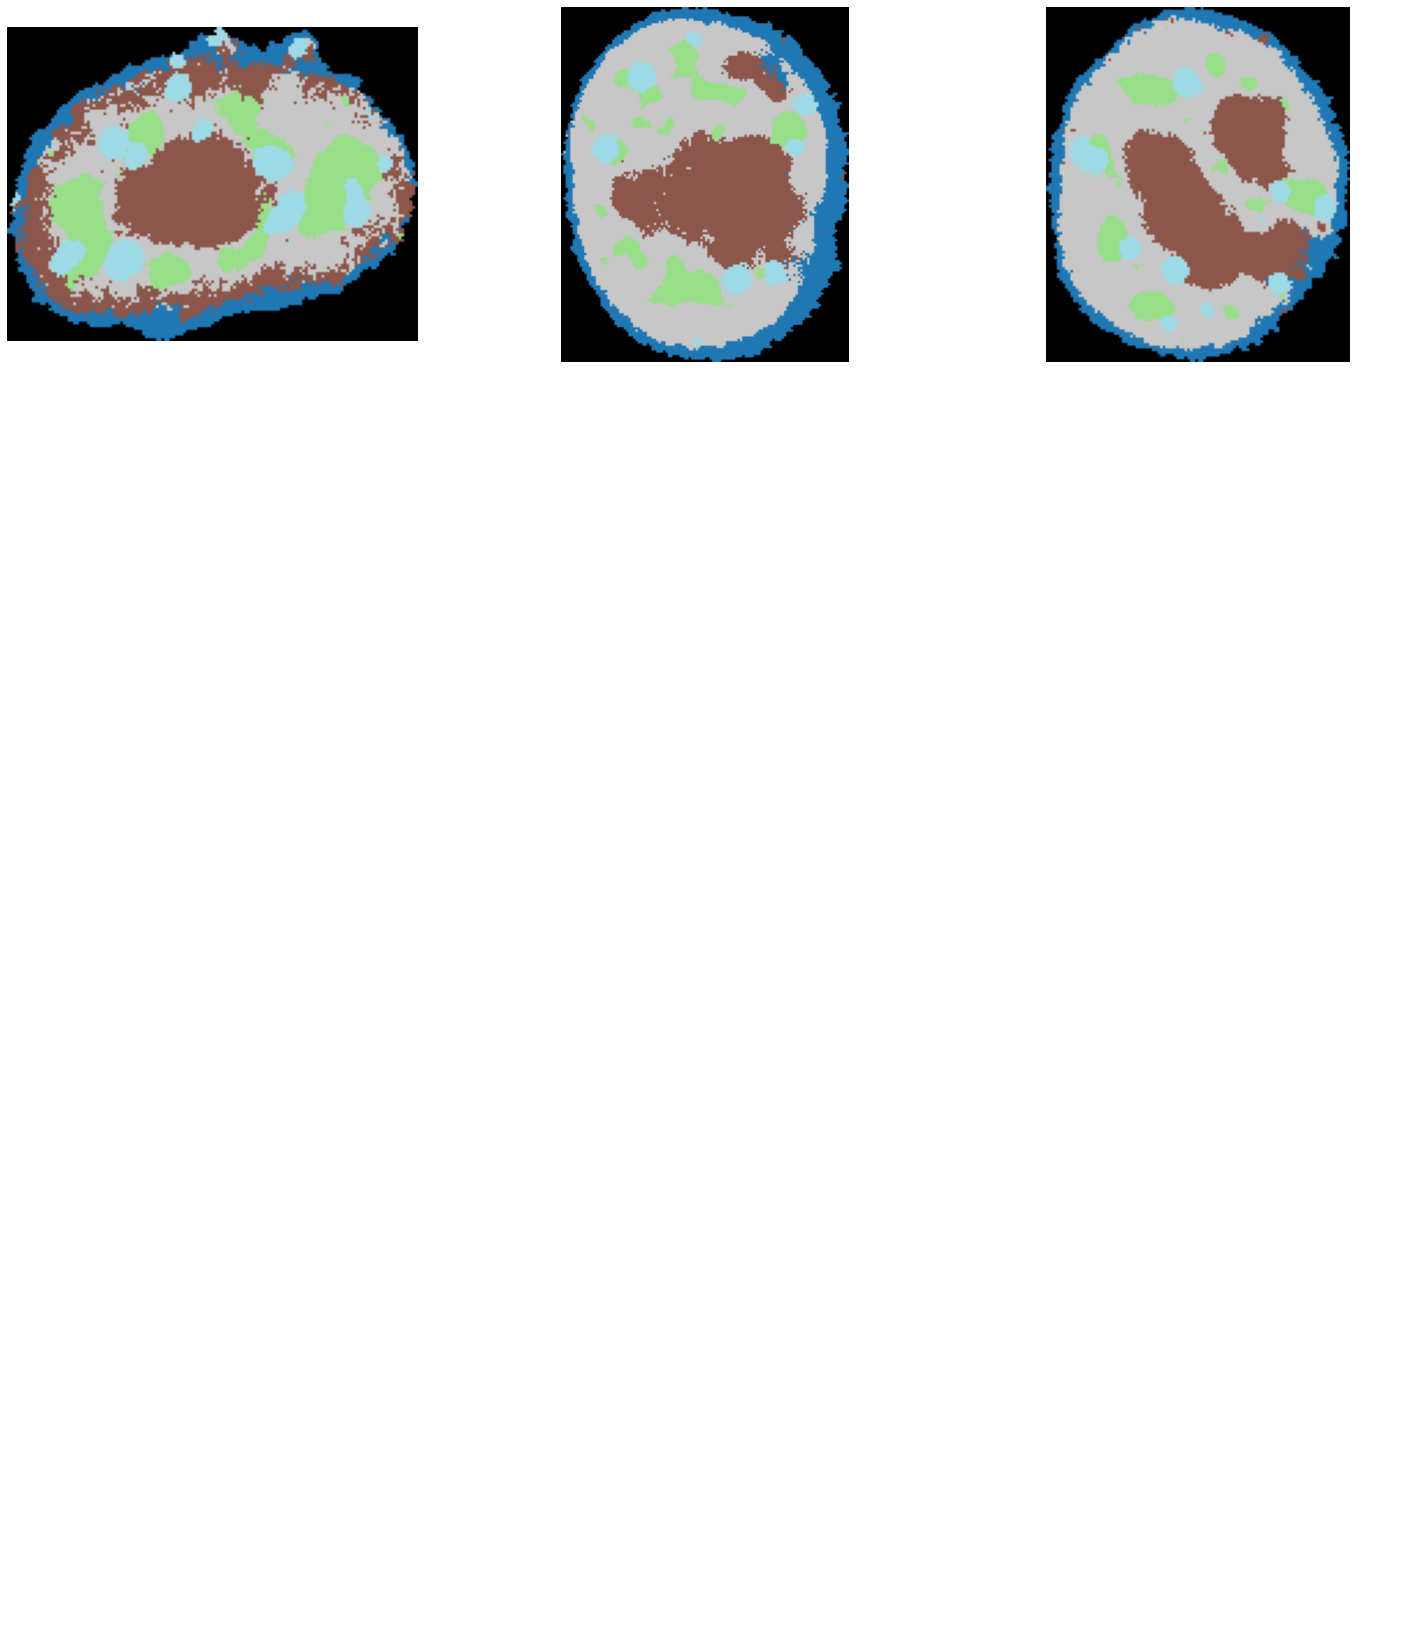

In [54]:
# check out cell colored by new annotation
fig, axes = plt.subplots(4, 3, figsize=(25, 30))
for j, data_dir in enumerate(["184A1_unperturbed/I09"]):
    for i in range(3):
        axes[j, i].imshow(
            annotate_img(
                example_cells["clustering_res0.2"][data_dir][i],
                annotation=cl.cluster_annotation,
                from_col=cl.config["cluster_name"],
                to_col="annotation",
                color=True,
            )
        )

for ax in axes.flat:
    ax.axis("off")

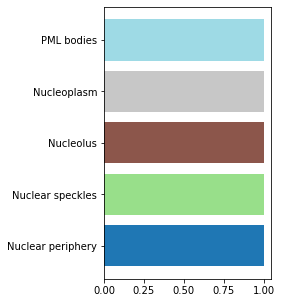

In [55]:
# legend
plt.rcParams["figure.figsize"] = [3, 5]
df = cl.cluster_annotation.groupby("annotation")["annotation_colors"].first()
plt.barh(y=range(len(df)), width=1, color=df)
_ = plt.yticks(range(len(df)), df.index, rotation=0)

## Predict model on full data
After generating a clustering on a subset of the data, we can now project it to the entire dataset. For this, the high-level API function `project_cluster_data` can be used. Alternatively, the cli can be used:
```
campa cluster test/CondVAE_pert-CC project aggregated/sub-0.1 --save-dir aggregated/full_data --cluster-name clustering_res0.2
```


In [59]:
project_cluster_data(
    "test/CondVAE_pert-CC",
    cluster_data_dir="aggregated/sub-0.1",
    cluster_name="clustering_res0.2",
    save_dir="aggregated/full_data",
    data_dir="184A1_unperturbed/I09",
)

Cannot read with memmap:  /Users/hannah.spitzer/projects/pelkmans/local_experiments/NascentRNA_new/test/CondVAE_pert-CC/aggregated/sub-0.1/clustering.npy
Cannot read with memmap:  /Users/hannah.spitzer/projects/pelkmans/local_experiments/NascentRNA_new/test/CondVAE_pert-CC/aggregated/sub-0.1/clustering_res0.2.npy
